In [160]:
import numpy as np
#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import scipy
import scipy.special

from abc import ABC, abstractmethod
from enum import Enum

import optuna
import math


# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gymnasium.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [161]:
MAX_EPISODE_STEPS = 200
ENV_SEED = 12345
NP_SEED = 12345

In [162]:
class Learning(ABC) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        self.env : gym.Env = gym.make('MountainCar-v0')
        self.env.reset(seed = ENV_SEED)
        self.env.action_space.seed(seed = ENV_SEED)
        self.rng = np.random.default_rng(seed = NP_SEED)

        self.alpha = alpha
        self.gamma = gamma
        self.spaceBins = spaceBins
        self.velBins = velBins

        self.spaceLinSpace = np.linspace(
            self.env.observation_space.low[0], 
            self.env.observation_space.high[0], spaceBins + 1
        )    # Between -1.2 and 0.6
        self.velLinSpace = np.linspace(
            self.env.observation_space.low[1], 
            self.env.observation_space.high[1], 
            velBins + 1
        )    # Between -0.07 and 0.07

    def oneEpisode(self, episodeIdx : int) :
        currentState = self.env.reset()[0]
        terminated = False
        totalReward = 0
        for episodeStep in range(0, MAX_EPISODE_STEPS) :
            action = self.chooseNextAction(currentState, episodeIdx, episodeStep)
            nextState, reward, terminated, _, _ = self.env.step(action)
            self.updateFunction(currentState, nextState, reward, action, episodeIdx, episodeStep)

            currentState = nextState
            totalReward += reward
            if (terminated) :
                break
        
        return totalReward

    def learn(self, maxEpisodeNum : int, episodeOut : int = math.inf) -> np.ndarray :
        rewardArray = np.zeros(maxEpisodeNum)
        for episodeIdx in range(0, maxEpisodeNum) :
            episodeReward = self.oneEpisode(episodeIdx)
            rewardArray[episodeIdx] = episodeReward

            if (episodeIdx == episodeOut) :
                if len(rewardArray[rewardArray == -MAX_EPISODE_STEPS]) == episodeIdx :
                    break

            self.updateAfterEpisode(maxEpisodeNum)
        return rewardArray

    def computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return (spaceSlot, velocitySlot)

    @abstractmethod
    def updateAfterEpisode(self, episodeIdx) :
        pass

    @abstractmethod
    def chooseNextAction(self, state, episodeIdx, episodeStep) -> int : 
        pass

    @abstractmethod
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None:
        pass


# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

## Q-Learning
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [163]:
class QLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, self.env.action_space.n])
        self.epsilon = 1

        
    def chooseNextAction(self, state, episodeIdx, episodeStep) -> int:
        # tau = self.computeTau(episodeIdx, episodeStep)
        spaceSlot, velSlot = self.computeSlots(state)
        # softmaxValue : np.ndarray = scipy.special.softmax(self.qFunction[spaceSlot][velSlot] / tau)
        # action = np.random.choice(len(softmaxValue), p=softmaxValue)
        if (self.rng.random() < self.epsilon) :
            action = self.env.action_space.sample()
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)

        #eta = self.alpha / (1 + 0.5 * episodeIdx)
        target = reward + self.gamma * np.max(self.qFunction[nextSpaceSlot][nextVelSlot])
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)

In [164]:

def run(episodes, is_training=True, render=False):

    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    env.reset(seed = ENV_SEED)
    np.random.seed(seed = NP_SEED)
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07

    if(is_training):
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # init a 20x20x3 array
    else:
        pass

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 2 / episodes # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards>-200):

            if is_training and rng.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards+=reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        rewards_per_episode[i] = rewards

    env.close()

    # Save Q table to file

    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.savefig(f'mountain_car.png')

    plt.plot(rewards_per_episode)



#run(10_000, is_training=True, render=False)

## SARSA
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [165]:
class SarsaLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1 

    def chooseNextAction(self, state, episodeIdx, episodeStep) -> int:
        # tau = self.computeTau(episodeIdx, episodeStep)
        spaceSlot, velSlot = self.computeSlots(state)
        # softmaxValue : np.ndarray = scipy.special.softmax(self.qFunction[spaceSlot][velSlot] / tau)
        # action = np.random.choice(len(softmaxValue), p=softmaxValue)
        if (self.rng.random() < self.epsilon) :
            action = self.env.action_space.sample()
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)
        nextAction = self.chooseNextAction(nextState, episodeIdx, episodeStep)

        target = reward + self.gamma * self.qFunction[nextSpaceSlot][nextVelSlot][nextAction]
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)

## Expected-SARSA

Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma E_{\pi}[Q(S',A') | S'] - Q(S,A)]$

e

$E_{\pi}[Q(S',A') | S'] = \sum_{a} \pi(a | S')Q(S',a)$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [169]:
class ExpectedSarsaLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1

    def chooseNextAction(self, state, episodeIdx, episodeStep) -> int:
        # tau = self.computeTau(episodeIdx, episodeStep)
        spaceSlot, velSlot = self.computeSlots(state)
        # softmaxValue : np.ndarray = scipy.special.softmax(self.qFunction[spaceSlot][velSlot] / self.tau)
        # action = np.random.choice(len(softmaxValue), p = softmaxValue)
        if (self.rng.random() < self.epsilon) :
            action = self.env.action_space.sample()
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        
        return action

    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextQValue = self.computeExpectedQValue(nextState, episodeIdx, episodeStep)
        
        target = reward + self.gamma * nextQValue
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)
        #self.tau = max(0.01, self.tau - 1 / maxEpisodeNum)
        pass


    def computeExpectedQValue(self, nextState, episodeIdx, episodeStep) :
        spaceSlot, velSlot = self.computeSlots(nextState)

        expectedQ = 0
        qMax = np.max(self.qFunction[spaceSlot, velSlot])
        greedyActions = 0
        for action in range(self.env.action_space.n) :
            if (self.qFunction[spaceSlot, velSlot, action] == qMax) :
                greedyActions += 1

        nonGreedyProb = self.epsilon / self.env.action_space.n
        greedyProb = (1 - self.epsilon) / greedyActions + nonGreedyProb
        for action in range(self.env.action_space.n) :
            if (self.qFunction[spaceSlot, velSlot, action] == qMax) :
                expectedQ += self.qFunction[spaceSlot, velSlot, action] * greedyProb
            else :
                expectedQ += self.qFunction[spaceSlot, velSlot, action] * nonGreedyProb
        
        return expectedQ

## Double Q-Learning

In [167]:
class DoubleQLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFun_1 : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.qFun_2 : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1

    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        randomValue = np.random.random()
        if (randomValue < 0.5) :
            toUpdate = self.qFun_1
            other = self.qFun_2
        else :
            toUpdate = self.qFun_2
            other = self.qFun_1

        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)
        nextAction = np.argmax(toUpdate[nextSpaceSlot][nextVelSlot])
        
        target = reward + self.gamma * other[nextSpaceSlot][nextVelSlot][nextAction]
        increment = self.alpha * (target - toUpdate[spaceSlot][velSlot][action])

        toUpdate[spaceSlot][velSlot][action] += increment

    def chooseNextAction(self, state, episodeIdx, episodeStep) -> int:
        ranValue = np.random.random()
        if (ranValue < self.epsilon) :
            return self.env.action_space.sample()
        else :
            spaceSlot, velSlot = self.computeSlots(state)
            return np.argmax(self.qFun_1[spaceSlot][velSlot] + self.qFun_2[spaceSlot][velSlot])
        
    def updateAfterEpisode(self, episodeNum):
        self.epsilon = max(self.epsilon - 2 / (episodeNum), 0.0)
        
    

## Tuning

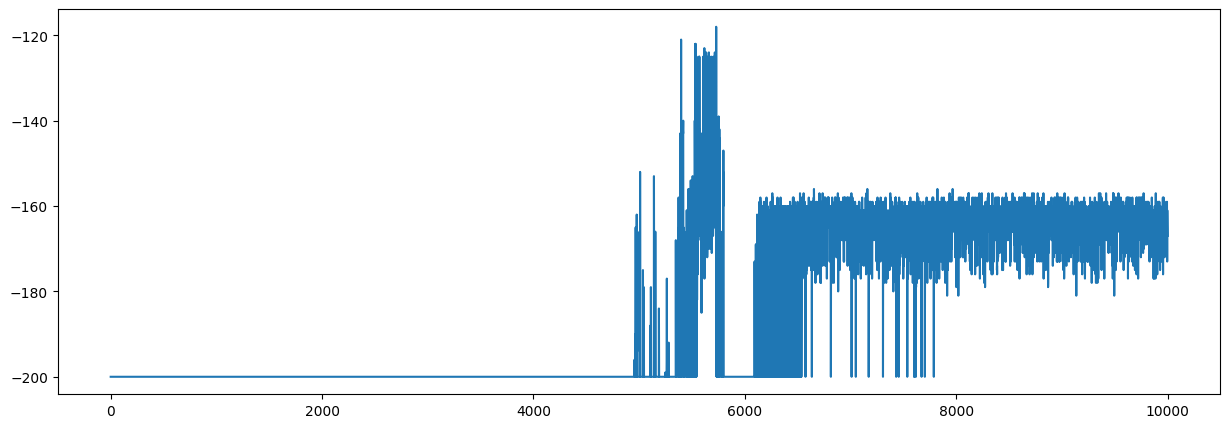

<Figure size 640x480 with 0 Axes>

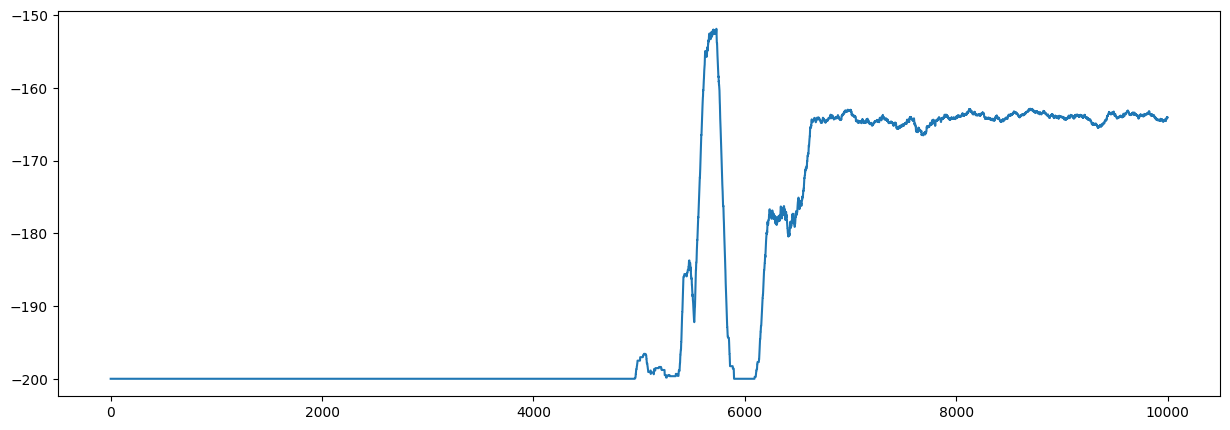

In [177]:
learning = QLearning(alpha = 0.9, gamma = 0.9, spaceBins = 20, velBins = 20)
rewardArray = learning.learn(maxEpisodeNum = 10_000, episodeOut = math.inf)
plt.figure(figsize=(15,5))
plt.plot(np.array(rewardArray))
plt.show()
plt.clf()
plt.figure(figsize=(15,5))

mean_rewards = np.zeros(10_000)
rewardSerie = pd.Series(rewardArray)
for t in range(10_000):
        mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

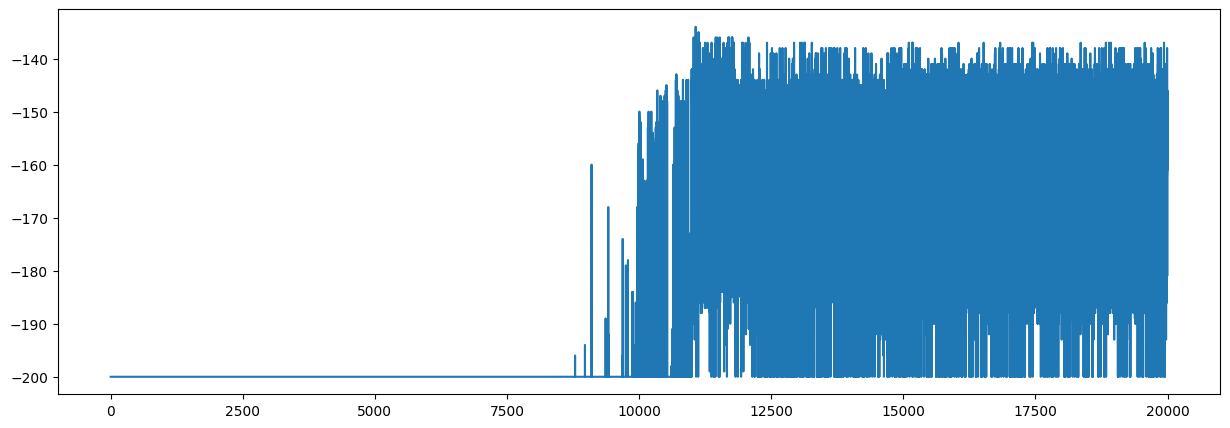

<Figure size 640x480 with 0 Axes>

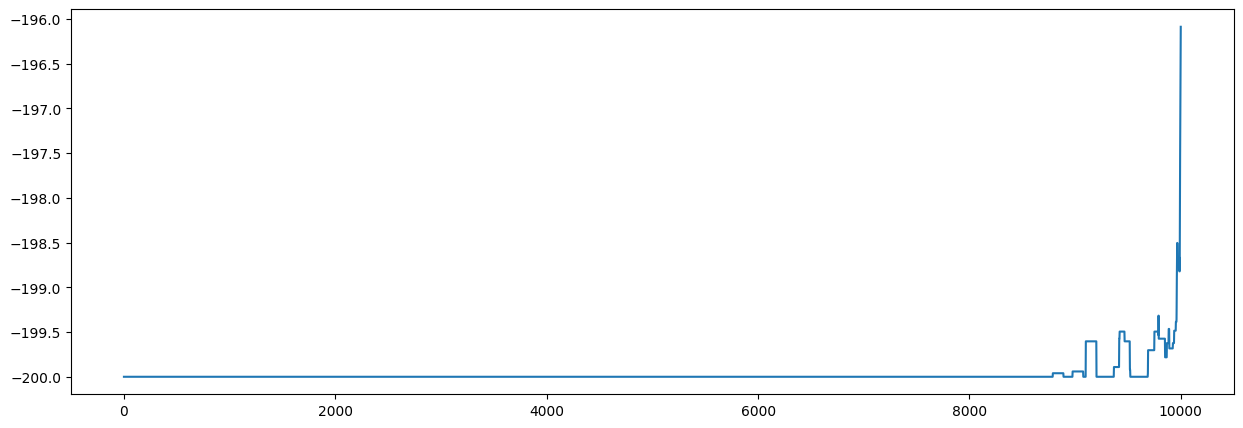

In [180]:
learning = QLearning(alpha = 0.60, gamma = 0.9, spaceBins = 20, velBins = 20)
rewardArray = learning.learn(maxEpisodeNum = 20_000, episodeOut = math.inf)
plt.figure(figsize=(15,5))
plt.plot(np.array(rewardArray))
plt.show()
plt.clf()
plt.figure(figsize=(15,5))

mean_rewards = np.zeros(20_000)
rewardSerie = pd.Series(rewardArray)
for t in range(20_000):
        mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

## Analisi e Confronti

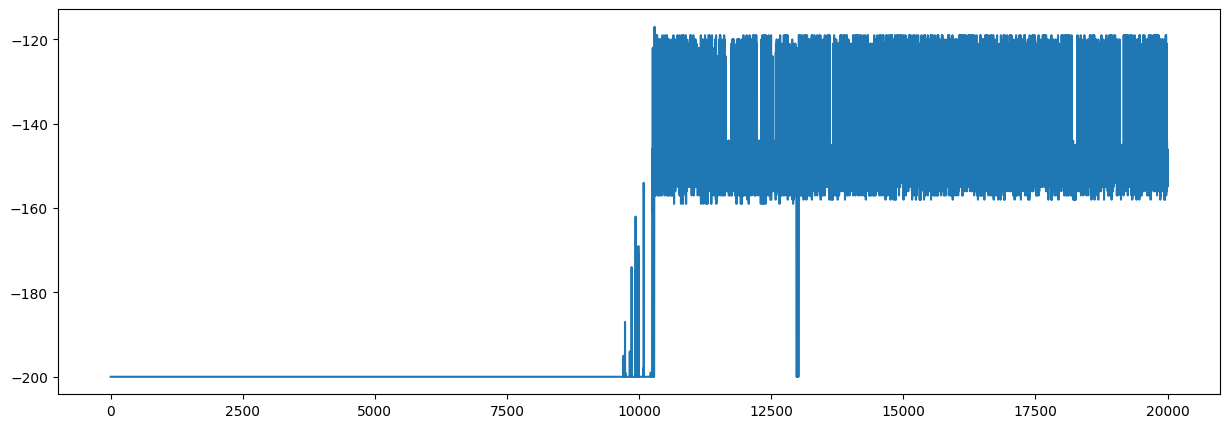

<Figure size 640x480 with 0 Axes>

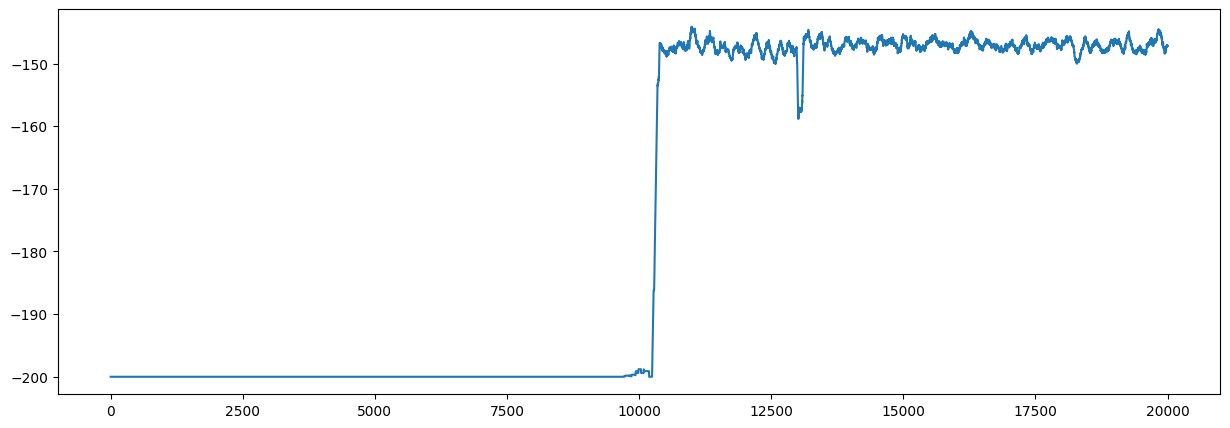

In [131]:
learning = SarsaLearning(alpha = 0.9, gamma = 0.9, spaceBins = 20, velBins = 20)
rewardArray = learning.learn(maxEpisodeNum = 20_000, episodeOut = math.inf)
plt.figure(figsize=(15,5))
plt.plot(np.array(rewardArray))
plt.show()
plt.clf()
plt.figure(figsize=(15,5))

mean_rewards = np.zeros(20_000)
rewardSerie = pd.Series(rewardArray)
for t in range(20_000):
        mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

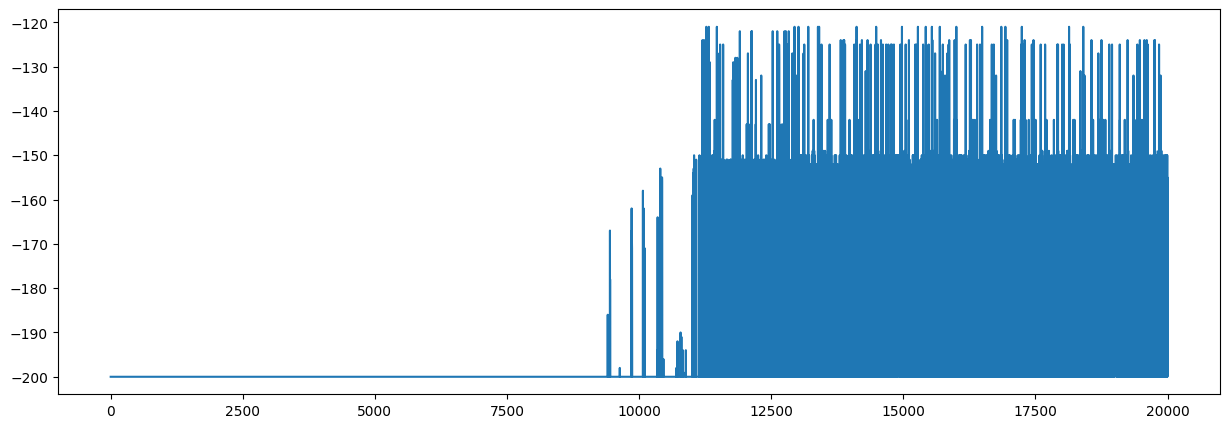

<Figure size 640x480 with 0 Axes>

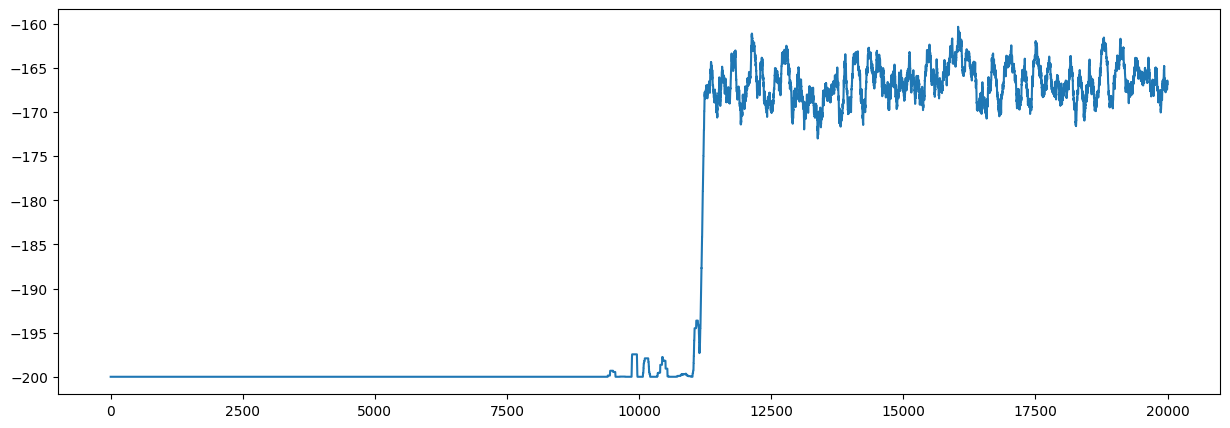

In [176]:
learning = ExpectedSarsaLearning(alpha = 0.9, gamma = 0.9, spaceBins = 20, velBins = 20)
rewardArray = learning.learn(maxEpisodeNum = 20_000, episodeOut = math.inf)
plt.figure(figsize=(15,5))
plt.plot(np.array(rewardArray))
plt.show()
plt.clf()
plt.figure(figsize=(15,5))

mean_rewards = np.zeros(20_000)
rewardSerie = pd.Series(rewardArray)
for t in range(20_000):
        mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

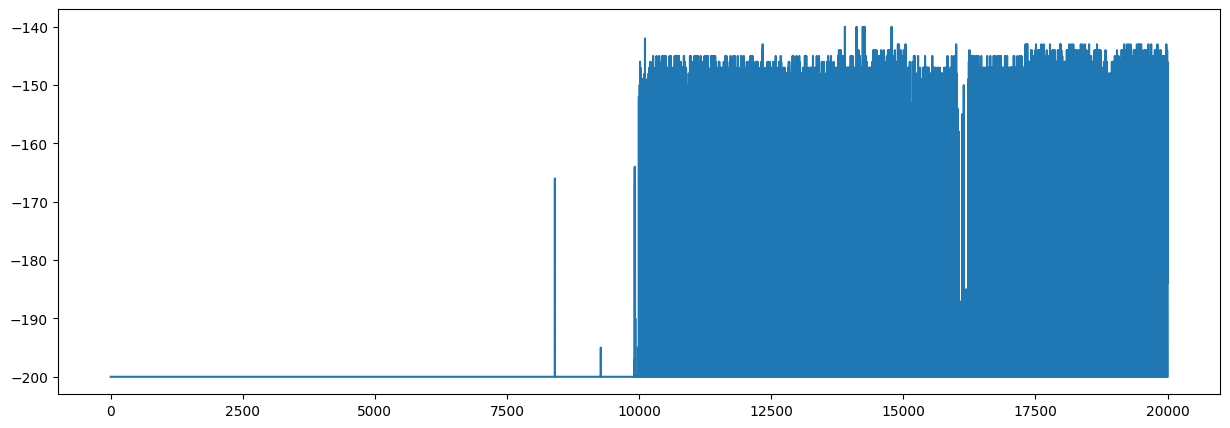

<Figure size 640x480 with 0 Axes>

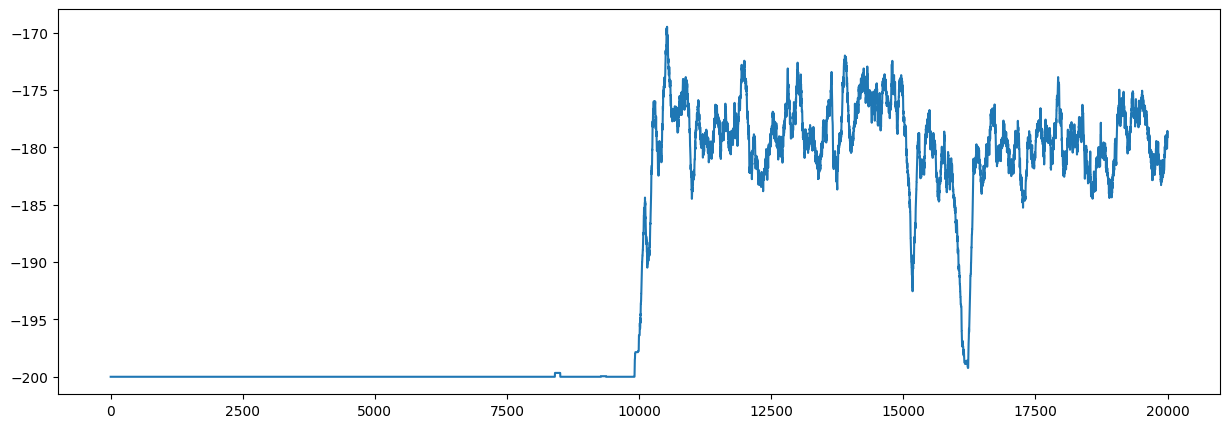

In [137]:
learning = DoubleQLearning(alpha = 0.9, gamma = 0.9, spaceBins = 20, velBins = 20)
rewardArray = learning.learn(maxEpisodeNum = 20_000, episodeOut = math.inf)
plt.figure(figsize=(15,5))
plt.plot(np.array(rewardArray[10_000 :]))
plt.show()
plt.clf()
plt.figure(figsize=(15,5))

mean_rewards = np.zeros(20_000)
rewardSerie = pd.Series(rewardArray)
for t in range(20_000):
        mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

# Soluzione con approssimazione

## Approssimazione Lineare

## Approssimazione con NQN